In [1]:
import torch,copy,argparse,csv
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

## Load data

In [2]:
velocity_coeff = np.genfromtxt('./data/POD_coeffs_3900_new_grid_221_42_Velocity_1.csv', delimiter=',')
pressure_coeff = np.genfromtxt('./data/POD_coeffs_3900_new_grid_221_42_Pressure_1.csv', delimiter=',')

In [3]:
coeff_all = torch.from_numpy(np.append(velocity_coeff,pressure_coeff,axis=0)).type(torch.FloatTensor)
scaler = MinMaxScaler()
scaler.fit(coeff_all.T)
coeff_all_scaled = torch.from_numpy(scaler.transform(coeff_all.T)).type(torch.FloatTensor)
data = copy.deepcopy(coeff_all_scaled[:-1,:])
label = copy.deepcopy(coeff_all_scaled[1:,:])

In [4]:
x_train, x_test, y_train, y_test = train_test_split(data,label, test_size=0.3 , random_state=2)

In [5]:
def norm_inverse(data_scaled, scaler):
    data = (data_scaled - torch.tensor(scaler.min_).type(torch.FloatTensor))/torch.tensor(scaler.scale_).type(torch.FloatTensor)
    return data

## Compute residuals

In [6]:
basis_v = torch.from_numpy(np.genfromtxt('./data/Velocity_basis.csv', delimiter=',')).type(torch.FloatTensor)
basis_p = torch.from_numpy(np.genfromtxt('./data/Pressure_basis.csv', delimiter=',')).type(torch.FloatTensor)

In [7]:
def backward_p(coeff_p, basis_p):
    length, number = coeff_p.shape
    nx = 221
    ny = 42
    grid_p = torch.matmul(basis_p, coeff_p)
    return grid_p.reshape(nx,ny,number)

In [8]:
def backward_v(coeff_v, basis_v):
    length, number = coeff_v.shape
    nx = 221
    ny = 42
    grid_v = torch.matmul(basis_v, coeff_v)
    grid_v1 = grid_v[0:nx*ny].reshape(nx,ny,number)
    grid_v2 = grid_v[nx*ny:].reshape(nx,ny,number)
    return grid_v1, grid_v2

In [9]:
def backward(coeff, basis_v, basis_p):
    nPOD = 10
    coeff_v = coeff[:nPOD,:]
    coeff_p = coeff[nPOD:,:]
    v1, v2 = backward_v(coeff_v, basis_v)
    p = backward_p(coeff_p, basis_p)
    return v1, v2, p

In [10]:
def compute_resids(coeff_scaled, coeff_pred_scaled, basis_v, basis_p, scaler):
#     coeff = scaler.inverse_transform(coeff_scaled)
    coeff =  norm_inverse(coeff_scaled, scaler)
    coeff_pred = norm_inverse(coeff_pred_scaled, scaler)
    u1_o1d, u2_o1d, p = backward(coeff.T, basis_v, basis_p)
    u1, u2, p = backward(coeff_pred.T, basis_v, basis_p)
    nx, ny = 221,42
    dx, dy = 0.01, 0.01
    dt = 1.
    sigma = 0.
    rho = 1.
    mu = 1./300
    # first order term of u1
    u1x = (u1[2:,1:-1] - u1[:-2,1:-1])/(2.0*dx)
    u1y = (u1[1:-1,2:] - u1[1:-1,:-2])/(2.0*dy)
#     u1t = (u1_new[1:-1, 1:-1] - u1 [1:-1, 1:-1] )/dt 
    u1t = (u1[1:-1, 1:-1] - u1_o1d[1:-1, 1:-1])/dt 
    # second order term of u1 
    u1xx = (u1[2:,1:-1] - 2. *u1[1:-1, 1:-1] + u1[0: -2, 1:-1])/(dx**2) 
    u1yy = (u1[1:-1,2:] - 2. *u1[1:-1, 1:-1] + u1[1:-1, 0:-2])/(dy**2) 
    # first order term of u2
    u2x = (u2[2:,1:-1] - u2[0:-2, 1:-1])/(2.0*dx) 
    u2y = (u2[1:-1, 2: ] - u2 [1:-1, 0:-2])/(2.0*dy) 
#     u2t = (u2_new[1:-1, 1:-1] - u2 [1:-1, 1:-1] )/dt 
    u2t = (u2[1:-1, 1:-1] - u2_o1d[1:-1, 1:-1] )/dt 
    # second order term of u2 
    u2xx = (u2[2:,1:-1] - 2.*u2[1:-1, 1:-1] + u2[0:-2, 1:-1])/(dx**2) 
    u2yy = (u2[1:-1,2:] - 2.*u2[1:-1, 1:-1] + u2[1:-1, 0:-2])/(dy**2) 
    # first order of p 
    px = (p[2:,1:-1] - p[0:-2,1:-1])/(2.* dx)
    py = (p[1:-1,2:] - p[1:-1,0:-2])/(2.* dy)
    r_cty = u1x + u2y 
    r_u1 = rho*u1t + sigma*u1 [1:-1, 1:-1]+ rho* (u1 [1:-1, 1:-1] *u1x+u2 [1:-1, 1:-1] *u1y) - mu* (u1xx+u1yy) + px
    r_u2 = rho*u2t + sigma*u2 [1: -1, 1: -1]+ rho* (u1 [1:-1, 1:-1] *u2x+u2 [1:-1, 1:-1] *u2y) - mu* (u2xx+u2yy) + py
    return r_cty, r_u1, r_u2

## Build model

In [11]:
## ========================模型验证======================
def valid(model,data,criterion):
    model.eval()
    z = torch.from_numpy(np.random.randn(data.shape[0], 10)).float() # 随机噪声
    with torch.no_grad():   # 不记录梯度信息
        y_pred = model(torch.cat([z, data], dim=1))
        loss = criterion(y_pred, y_test)
        loss_val.append(loss.item())
        print('val MSE loss:',loss.item())

In [12]:
# 网络G，用于预测下一时刻的特征向量
G = torch.nn.Sequential(
    torch.nn.Linear(20+10,30),   # 特征向量+噪声向量
    torch.nn.ReLU(),   
    torch.nn.Linear(30,15), 
    torch.nn.ReLU(),   
    torch.nn.Linear(15,20),   
)
# 网络D，用于一组特征向量是网络G制造的还是真实标签，促使G的输出接近于真实标签
D = torch.nn.Sequential(
    torch.nn.Linear(20,10),   
    torch.nn.ReLU(),   
    torch.nn.Linear(10,5), 
    torch.nn.ReLU(),   
    torch.nn.Linear(5,1),
    nn.Sigmoid()   
)

In [13]:
loss_func_bce = nn.BCELoss()    # 用于鉴别器模型D（对抗损失），D的任务判断是否为标签，属于二分类任务，因此用交叉熵损失
loss_func_reg = nn.MSELoss()    # 用于生成器G，计算模型预测和标签的差异，因为是回归任务所以用均方根损失
opt_g = torch.optim.Adam(G.parameters(), lr=3e-4)   
opt_d = torch.optim.Adam(D.parameters(), lr=1e-4)

In [14]:
loss_train = []
loss_val = []

## Training

In [15]:
dataset_train = Data.TensorDataset(x_train , y_train)
batch_size = 60
loader = Data.DataLoader(
    dataset = dataset_train,
    batch_size = batch_size,
    shuffle=True,
    num_workers = 8
)
epochs = 10
lambda_res = 0.01

In [16]:
for epoch in range(epochs):
    print('epoch:',epoch)
    for step , (batch_x,batch_y) in enumerate(loader):
        # 训练判别器D，目的是能够区分G的输出和真实标签
        for d in range(1):
            D.train()
            G.eval()
            # 前向传播
            z=torch.from_numpy(np.random.randn(batch_x.shape[0], 10)).float()   # 随机噪声
            d_real = D(batch_y)     #  （标签）输入判别器的结果
            batch_y_pred = G(torch.cat([z, batch_x], dim=1))      #  （噪声+x）输入生成器，得到预测结果
            d_gen = D(batch_y_pred)        #  （预测结果）输入判别器的结果
            # 计算损失
            Dloss_real = loss_func_bce(d_real, torch.ones((batch_x.shape[0],1))) # 对于（标签+x）组，判别器输出应趋向于全1
            Dloss_gen = loss_func_bce(d_gen, torch.zeros((batch_x.shape[0],1)))  # 对于（预测结果+x）组，判别器输出应趋向于全0
            Dloss = Dloss_real + Dloss_gen
            # 反向传播（只对判别器参数进行更新）
            Dloss.backward()
            opt_d.step()
            opt_d.zero_grad()
            opt_g.zero_grad()
        # 训练生成器G，目的是G的输出能够欺骗D，让D以为G的输出就是真实标签
        for g in range(3):
            D.eval()
            G.train()
            # 前向传播
            z = torch.from_numpy(np.random.randn(batch_x.shape[0], 10)).float() # 随机噪声
            batch_y_pred = G(torch.cat([z, batch_x], dim=1))
            d_gen = D(batch_y_pred)  
            # 计算损失函数
            Gloss_adventure = 0.3 * loss_func_bce(d_gen, torch.ones((batch_x.shape[0],1)))   # G的目的是，让D以为它的输出就是真实标签，因此G趋向于让d_gen等于1
            Gloss_regression = loss_func_reg(batch_y_pred,batch_y)
            r_cty_pred, r_u1_pred, r_u2_pred = compute_resids(batch_x, batch_y_pred, basis_v, basis_p,scaler)
            r_cty, r_u1, r_u2 = compute_resids(batch_x, batch_y, basis_v, basis_p,scaler)
#             r_cty, r_u1, r_u2 = compute_resids(batch_y, batch_y_pred, basis_v, basis_p, scaler)
            Gloss_res = torch.norm(r_cty_pred-r_cty)+torch.norm(r_u1_pred-r_u1)+torch.norm(r_u2_pred-r_u2)
            Gloss = Gloss_regression + Gloss_adventure + lambda_res*Gloss_res
            # 反向传播
            Gloss.backward()
            opt_g.step()
            opt_g.zero_grad()
            opt_d.zero_grad()
            loss_train.append(Gloss_regression.item())
            valid(G,x_test,loss_func_reg)
        D.eval()
        G.eval()
        print('train D loss:', Dloss.detach().item(), 'G loss:', Gloss.detach().item())

epoch: 0
val MSE loss: 0.2793005108833313
val MSE loss: 0.27761226892471313
val MSE loss: 0.2768770754337311
train D loss: 1.418960690498352 G loss: 143.44589233398438
val MSE loss: 0.27434420585632324
val MSE loss: 0.27432015538215637
val MSE loss: 0.2729452848434448
train D loss: 1.4174729585647583 G loss: 133.49781799316406
val MSE loss: 0.27200090885162354
val MSE loss: 0.26969555020332336
val MSE loss: 0.26904240250587463
train D loss: 1.4158588647842407 G loss: 126.17159271240234
val MSE loss: 0.2674330770969391
val MSE loss: 0.2665795385837555
val MSE loss: 0.26484057307243347
train D loss: 1.4155926704406738 G loss: 125.72518920898438
val MSE loss: 0.2635948359966278
val MSE loss: 0.26298749446868896
val MSE loss: 0.26187118887901306
train D loss: 1.4169732332229614 G loss: 124.88496398925781
val MSE loss: 0.2611386775970459
val MSE loss: 0.25888916850090027
val MSE loss: 0.2580789029598236
train D loss: 1.415212869644165 G loss: 123.2328109741211
val MSE loss: 0.25616112351417

val MSE loss: 0.12581747770309448
val MSE loss: 0.12530983984470367
train D loss: 1.4111721515655518 G loss: 62.04731369018555
val MSE loss: 0.1254795640707016
val MSE loss: 0.12400101870298386
val MSE loss: 0.12455303966999054
train D loss: 1.4127888679504395 G loss: 61.46040344238281
val MSE loss: 0.12269020825624466
val MSE loss: 0.12332387268543243
val MSE loss: 0.12340070307254791
train D loss: 1.4124114513397217 G loss: 64.65586853027344
val MSE loss: 0.12258543074131012
val MSE loss: 0.12136173248291016
val MSE loss: 0.1218225285410881
train D loss: 1.4123907089233398 G loss: 61.09112548828125
val MSE loss: 0.1204843744635582
val MSE loss: 0.12026676535606384
val MSE loss: 0.11963029205799103
train D loss: 1.4116592407226562 G loss: 63.25872802734375
val MSE loss: 0.11947114765644073
val MSE loss: 0.11926993727684021
val MSE loss: 0.11832230538129807
train D loss: 1.4149783849716187 G loss: 62.7800407409668
val MSE loss: 0.11735239624977112
val MSE loss: 0.11746913939714432
val 

val MSE loss: 0.06785819679498672
val MSE loss: 0.06740575283765793
train D loss: 1.4146966934204102 G loss: 55.08308410644531
val MSE loss: 0.06759887933731079
val MSE loss: 0.06724801659584045
val MSE loss: 0.06702128797769547
train D loss: 1.4154908657073975 G loss: 54.66410446166992
val MSE loss: 0.0668184831738472
val MSE loss: 0.0665091872215271
val MSE loss: 0.06624428182840347
train D loss: 1.4127521514892578 G loss: 55.24779510498047
val MSE loss: 0.06604351103305817
val MSE loss: 0.06596056371927261
val MSE loss: 0.06547468155622482
train D loss: 1.4144699573516846 G loss: 54.10057067871094
val MSE loss: 0.06541287899017334
val MSE loss: 0.06475550681352615
val MSE loss: 0.06499890983104706
train D loss: 1.413578987121582 G loss: 55.931304931640625
val MSE loss: 0.0646093413233757
val MSE loss: 0.06412123888731003
val MSE loss: 0.06348903477191925
train D loss: 1.417458415031433 G loss: 51.91891860961914
val MSE loss: 0.06376224011182785
val MSE loss: 0.0636594370007515
val M

val MSE loss: 0.04714329168200493
val MSE loss: 0.046994760632514954
val MSE loss: 0.04706708714365959
train D loss: 1.4242143630981445 G loss: 41.986080169677734
val MSE loss: 0.046765267848968506
val MSE loss: 0.04669083654880524
val MSE loss: 0.04664085805416107
train D loss: 1.4224684238433838 G loss: 44.705509185791016
val MSE loss: 0.04680401086807251
val MSE loss: 0.04646476358175278
val MSE loss: 0.04611187055706978
train D loss: 1.4207912683486938 G loss: 44.8004150390625
val MSE loss: 0.046719085425138474
val MSE loss: 0.04650105908513069
val MSE loss: 0.04594433680176735
train D loss: 1.4184770584106445 G loss: 45.00968551635742
val MSE loss: 0.04622650146484375
val MSE loss: 0.04661353677511215
val MSE loss: 0.04613933712244034
train D loss: 1.4216070175170898 G loss: 45.58412551879883
val MSE loss: 0.0467674545943737
val MSE loss: 0.046308424323797226
val MSE loss: 0.046379782259464264
train D loss: 1.4234561920166016 G loss: 43.953243255615234
val MSE loss: 0.046320140361

val MSE loss: 0.040934208780527115
val MSE loss: 0.040640171617269516
val MSE loss: 0.04044407978653908
train D loss: 1.423866868019104 G loss: 35.75636291503906
val MSE loss: 0.0406557060778141
val MSE loss: 0.04060063883662224
val MSE loss: 0.04069562628865242
train D loss: 1.4217021465301514 G loss: 31.998456954956055
val MSE loss: 0.040455203503370285
val MSE loss: 0.0406210720539093
val MSE loss: 0.04018067196011543
train D loss: 1.421972393989563 G loss: 35.9853401184082
val MSE loss: 0.0403856597840786
val MSE loss: 0.04042508453130722
val MSE loss: 0.04019646346569061
train D loss: 1.4221103191375732 G loss: 33.228782653808594
val MSE loss: 0.04028748348355293
val MSE loss: 0.04041828215122223
val MSE loss: 0.04036225751042366
train D loss: 1.4203804731369019 G loss: 32.69038772583008
val MSE loss: 0.04044921323657036
val MSE loss: 0.04037968069314957
val MSE loss: 0.040409598499536514
train D loss: 1.4214246273040771 G loss: 30.152952194213867
val MSE loss: 0.04042986407876015

GAN_with_noise——测试集均方误差： 0.038310032337903976


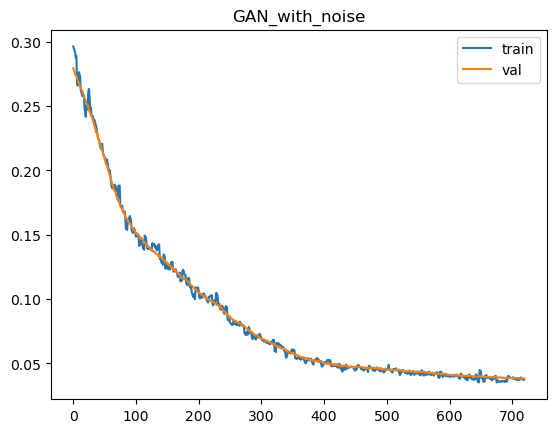

In [17]:
x = [i for i in range(len(loss_train))]    # 每一轮G都训练了3次，所以乘3
plt.plot(x,loss_train, label='train')
plt.plot(x,loss_val, label='val')
plt.title('GAN_with_noise')
plt.legend()
plt.savefig(fname="results/GAN_with_noise.png")
np.save('results/GAN_with_noise.npy',loss_train)   # 保存为npy文件,供不同方法对比
print('GAN_with_noise——测试集均方误差：',loss_val[-1])
plt.show()

In [18]:
G.eval()
z = torch.from_numpy(np.random.randn(data.shape[0], 10)).float() # 随机噪声
coeff_pred = G(torch.cat([z, data], dim=1))
np.savetxt('./results/prediction_res_GAN_scaled.csv', coeff_pred.detach().numpy(), delimiter=',')